## 使用$(x,y)$坐标训练
### 1：模型设置

In [127]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # 神经ODE库

df = pd.read_csv('./xy_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]/100
y = array[1:]/1e10

coords = torch.tensor(y.T, dtype=torch.float32)
t_tensor = torch.tensor(t,dtype=torch.float32)

print(coords.shape)

#定义Stan激活函数
class StanActivation(nn.Module):
    def __init__(self, num_neurons):
        """
        初始化 Stan 激活函数。
        :param num_neurons: 每层的神经元数量，用于定义 beta 参数的大小
        """
        super(StanActivation, self).__init__()
        # 使用 nn.Parameter 初始化 beta，使其参与反向传播
        self.beta = nn.Parameter(torch.ones(num_neurons) * 0.1)  # 使用较小值初始化 beta
    
    def forward(self, x):
        """
        Stan 激活函数的前向计算
        :param x: 输入张量
        :return: 应用 Stan 激活函数后的输出张量
        """
        # 确保 beta 参与计算图
        return (1 + self.beta * x) * torch.tanh(x)

# 2. 定义ODE模型
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 50),
            nn.Tanh(),
            nn.Linear(50, 50)  
        )
        self.fc1 = nn.Linear(50,30)
        self.stan = StanActivation(30)
        self.fc2 = nn.Linear(30,4)

    def forward(self, t, y):
        y = self.net(y)
        y= torch.sin(y)
        y = self.fc1(y)
        y = self.stan(y)
        y = self.fc2(y)

        return y

# 早停用函数
def errors(data):
    mean_value = np.mean(data)
    errors = data - mean_value
    absolute_errors = np.abs(errors)
    mae = np.mean(absolute_errors)
    return mae

'''# 初始化ODE函数和模型
model = ODEFunc()
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=1e-3)
criterion = nn.MSELoss()
epochs = 2000'''

# 超参数设置
loss_value = []
mini_delta = 0.005
sum_ = np.array([0,0,0,0,0])

# 定义训练函数
def train(model,optimizer,criterion,epochs):
    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        
        # 神经ODE求解
        pred_y = odeint(model, coords[0], t_tensor)
        
        # 计算损失
        loss = criterion(pred_y, coords)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 打印损失
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

        #设置早停
        loss_value.append(loss.item())
        if epoch > 5:
            for i in range(5):
                sum_[i] = loss_value[epoch]-loss_value[epoch-i-1]
        err = errors(sum_)

        if loss.item() < 0.01 and err < 0.001 :
            torch.save(model.state_dict(), 'copy_model_params.pth')
            break

torch.Size([8760, 4])


## 引入守恒量（PINN）
### 1.能量守恒
$$
E = K + V
$$
$$
E = \frac{1}{2}(\dot{x}^2+\dot{y}^2) - \frac{GM}{\sqrt{x^2+y^2}}
$$

### 2.角动量守恒
$$ 
L = \vec{r} \times \vec{p}
$$
$$
L = x\dot{y}-y\dot{x}
$$

In [128]:
# 加入PINN

# 初始条件
G = 6.67430e-11  # 引力常数, m^3 kg^-1 s^-2
M = 1.989e30     # 太阳质量, kg
#r0 = [1.496e11, 0]#初始位置 m
#v0 = [0,30.29e3 ] #初始速度 m/s
#m = 5.972e24     # 地球质量 kg
print(y.shape)

#统一单位
G = G*86400**2 / 1e30
#r0 =r0/1e10
#v0 = v0 * 86400 / 1e10

def energy(Y, G, M):
    x, y, vx, vy = Y[:,0],Y[:,1],Y[:,2],Y[:,3]
    K = (vx**2 + vy**2)/2 - G*M/torch.sqrt(x**2 + y**2)
    return K

def angle(Y,G,M):
    x, y, vx, vy = Y[:,0],Y[:,1],Y[:,2],Y[:,3]
    l = x*vy-y*vx
    return l

energy0 = energy(coords,G,M)
angle0 = angle(coords,G,M)

print(energy0,angle0)
print(energy0.shape,angle0.shape)

class CustomLoss:
    def __init__(self, alpha=0.1, beta=0.1):
        self.alpha = alpha
        self.beta = beta

    def __call__(self, y, y_target):
        trajectory_loss = 30 * torch.mean((y - y_target)**2)
        energy_loss = torch.mean((energy(y,G,M)-energy0)**2)
        angle_loss = torch.mean((angle(y,G,M)-angle0)**2)
        if self.alpha != 0 and self.beta != 0:
            return trajectory_loss  + self.alpha * energy_loss + self.beta * angle_loss
        if self.alpha == 0 and self.beta != 0:
            return trajectory_loss  + self.beta * angle_loss
        if self.beta == 0 and self.alpha != 0:
            return trajectory_loss  + self.alpha * energy_loss
        if self.beta == 0 and self.alpha == 0:
            return trajectory_loss

(4, 8760)
tensor([-0.0331, -0.0331, -0.0331,  ..., -0.0331, -0.0331, -0.0331]) tensor([3.8497, 3.8497, 3.8497,  ..., 3.8497, 3.8497, 3.8497])
torch.Size([8760]) torch.Size([8760])


### 2.模型训练

In [129]:

model = ODEFunc()
model.load_state_dict(torch.load('copy_model_params.pth',weights_only='true'))
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)
criterion = CustomLoss(0.1,0.01)
#criterion = nn.MSELoss()
epochs = 1000

train(model,optimizer,criterion,epochs)

Epoch 0, Loss: 0.04483963921666145
Epoch 10, Loss: 0.25761228799819946
Epoch 20, Loss: 0.09246159344911575
Epoch 30, Loss: 0.1424015760421753
Epoch 40, Loss: 0.047644320875406265
Epoch 50, Loss: 0.05795012414455414
Epoch 60, Loss: 0.0464041642844677
Epoch 70, Loss: 0.04432258754968643
Epoch 80, Loss: 0.04418160021305084
Epoch 90, Loss: 0.04415477439761162
Epoch 100, Loss: 0.04414123296737671
Epoch 110, Loss: 0.04409175366163254
Epoch 120, Loss: 0.04402817413210869
Epoch 130, Loss: 0.04399539902806282
Epoch 140, Loss: 0.043960120528936386
Epoch 150, Loss: 0.04392670840024948
Epoch 160, Loss: 0.043892599642276764
Epoch 170, Loss: 0.04385848715901375
Epoch 180, Loss: 0.04382459074258804
Epoch 190, Loss: 0.043789684772491455
Epoch 200, Loss: 0.043753452599048615
Epoch 210, Loss: 0.04371681064367294
Epoch 220, Loss: 0.04368007555603981
Epoch 230, Loss: 0.043642375618219376
Epoch 240, Loss: 0.04360454902052879
Epoch 250, Loss: 0.04356536269187927
Epoch 260, Loss: 0.04352554678916931
Epoch 27

In [130]:
train(model,optimizer,criterion,epochs)

Epoch 0, Loss: 0.039184682071208954
Epoch 10, Loss: 0.03911213204264641
Epoch 20, Loss: 0.03903927654027939
Epoch 30, Loss: 0.03896697610616684
Epoch 40, Loss: 0.038892943412065506
Epoch 50, Loss: 0.038819245994091034
Epoch 60, Loss: 0.03874564170837402
Epoch 70, Loss: 0.038674190640449524
Epoch 80, Loss: 0.038890570402145386
Epoch 90, Loss: 0.09205806255340576
Epoch 100, Loss: 0.11173950135707855
Epoch 110, Loss: 0.062053192406892776
Epoch 120, Loss: 0.04690159112215042
Epoch 130, Loss: 0.041333768516778946
Epoch 140, Loss: 0.03926088660955429
Epoch 150, Loss: 0.03842078149318695
Epoch 160, Loss: 0.038122497498989105
Epoch 170, Loss: 0.03806264325976372
Epoch 180, Loss: 0.03800198435783386
Epoch 190, Loss: 0.037918850779533386
Epoch 200, Loss: 0.03785660117864609
Epoch 210, Loss: 0.037790447473526
Epoch 220, Loss: 0.03772609680891037
Epoch 230, Loss: 0.037661656737327576
Epoch 240, Loss: 0.03759751468896866
Epoch 250, Loss: 0.03753245621919632
Epoch 260, Loss: 0.03746847063302994
Epoc

KeyboardInterrupt: 

In [131]:
train(model,optimizer,criterion,epochs)

Epoch 0, Loss: 0.033919427543878555


KeyboardInterrupt: 

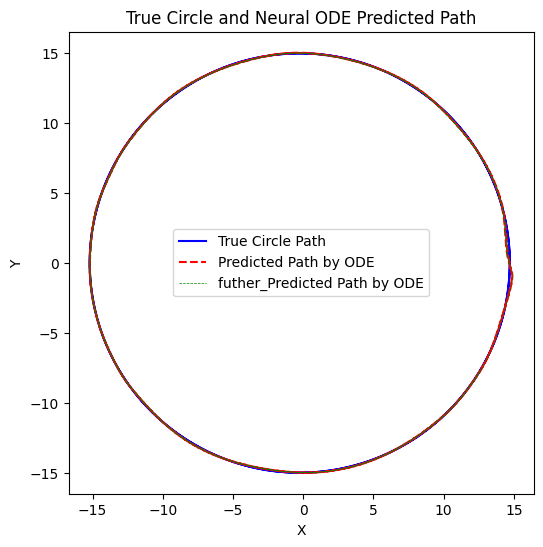

In [132]:
# 4. 可视化结果
model.eval()
time = torch.linspace(0,7,700*12)
with torch.no_grad():
    pred_y = odeint(model, coords[0], t_tensor)
    pred_y = pred_y.numpy()
    pred_y2 = odeint(model, coords[-1], time)
    pred_y2 = pred_y2.numpy()


# 绘制真实轨迹和预测轨迹
plt.figure(figsize=(6, 6))
plt.plot(y[0],y[1] , 'b-', label="True Circle Path")
plt.plot(pred_y[:, 0], pred_y[:, 1], 'r--', label="Predicted Path by ODE")
plt.plot(pred_y2[:, 0], pred_y2[:, 1], 'g--',linewidth = 0.5, label="futher_Predicted Path by ODE")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('True Circle and Neural ODE Predicted Path')
plt.axis('equal')
plt.legend()

plt.show()

In [133]:
torch.save(model.state_dict(), 'copy_model_params.pth')